# interpolate time dependent llc variable along trajectories

Right now there are lots of gaps as a diagnostic computed on one tile

Zoé to do (maybe):

- rechunk such as it looks more like snapshots
- add other variables (sea level, sst, sss, wind)


In [1]:
import os

import numpy as np
import pandas as pd
import xarray as xr
import dask.dataframe as dd

%matplotlib inline
from matplotlib import pyplot as plt

import pyinterp
import pyinterp.backends.xarray

import mitequinox.plot as pl
import mitequinox.utils as ut
#import mitequinox.parcels as pa
from mitequinox.parcels import store_parquet

INFO: Compiled ParcelsRandom ==> /dev/shm/pbs.5932834.datarmor0/parcels-55081/libparcels_random_6001bbaa-cc3c-41af-9622-b77c0068320a.so


In [2]:
if False:
    from dask.distributed import Client
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(processes=4, cores=4)
    #w = cluster.scale(jobs=15) # heavier data processing
    w = cluster.scale(jobs=10)
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster(n_workers=2, threads_per_worker=1)
    client = Client(cluster)
    client

In [3]:
#print(cluster.job_script())

---

## load data

In [6]:
site = "california"
site_dir = os.path.join(ut.diag_dir, "regional_"+site)

In [4]:
#ds = xr.open_zarr(os.path.join(site_dir, "llc.zarr") )
df = dd.read_parquet(os.path.join(site_dir, "llc_parcels_time_mean"))
df = df.repartition(npartitions=500).persist()

---

## interpolate new diagnostic along drifter tracks

ds is not properly chunked at the moment

In [7]:
df.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity,sea_level_mean,zonal_velocity_mean,temperature_mean,meridional_velocity_mean,salinity_mean
time,,,,,,,,,,,,,,
2011-11-15,38000612,43.223770,-152.822922,0.0,0.0,0.0,0.0,0.0,0.0,0.301963,0.111188,11.264963,-0.047701,32.847267
2011-11-15,38000637,43.223770,-151.781250,0.0,0.0,0.0,0.0,0.0,0.0,0.289056,0.094942,11.465209,0.017127,32.781781
2011-11-15,38000661,42.514122,-150.739578,0.0,0.0,0.0,0.0,0.0,0.0,0.323792,0.107724,12.161278,-0.024647,32.890323
2011-11-15,38000685,41.797028,-149.697922,0.0,0.0,0.0,0.0,0.0,0.0,0.352433,0.089004,13.222504,-0.016940,33.018796
2011-11-15,38000692,46.660358,-149.697922,0.0,0.0,0.0,0.0,0.0,0.0,0.242264,0.074070,8.888128,0.006434,32.550297


In [8]:
def interp(df):

    if hasattr(df, "time"):
        t = df["time"].unique()[0]
    elif df.index.name == "time":
        # dask dataframe
        t = df.index.unique()[0]
    elif hasattr(df, "name"):
        # when mapped after groupby
        t = df.name
    else:
        assert False, "Cannot find float id"

    diag = load_instantaneous_diagnostic(t)

    # interpolate on tracks
    for v in diag:
        df[v] = interp_snapshot(diag[v], df)

    return df
    

def load_instantaneous_diagnostic(t):
    
    # overwrite default with threaded scheduler    
    # "single-threaded"
    import dask
    
    with dask.config.set(scheduler="single-threaded"):

        # load data
        # not properly chunked
        #ds = xr.open_zarr(os.path.join(site_dir, "llc.zarr") )
        #ds = xr.open_zarr(os.path.join(ut.ref_data_dir, "SSU.zarr") ).rename({"i_g": "i"})
        #ds = ds.sel(face=10)
        #grd = (xr.open_zarr(os.path.join(ut.ref_data_dir, "grid.zarr") )[["XC", "YC"]]
        #       .sel(face=10)
        #       .rename({"XC": "lon", "YC": "lat"})
        #      )
        #ds = xr.merge([ds, grd])
        #ds = ds.sel(time=t, method="nearest")
        
        #diag_dir = '/home/datawork-lops-osi/equinox/mit4320/diags/'
        ds = xr.merge([(xr.open_zarr(os.path.join(ut.diag_dir,"dEta_"+_dir+"_california.zarr"))
                        .sel(time=t, method="nearest")
                        .rename({"dEta_"+_dir+"_california": "dEta_"+_dir})
                        .rename({"XC": "lon", "YC": "lat"})
                       )
                       for _dir in ["dx", "dy"]]
                     )
        
        # build diagnostic
        #diag = 0.5*(ds["meridional_velocity"]**2+ds["zonal_velocity"]**2)        
        #diag = ds["SSU"].compute()
        diag = ds.compute()
         
    return diag

def interp_snapshot(da, df):

    # prepare interpolator
    mesh = pyinterp.RTree()
    lons = da.lon
    lats = da.lat
    mesh.packing(
        np.vstack((lons.values.flatten(), lats.values.flatten())).T,
        da.values.flatten(),
    )

    # target positions
    lon = df["lon"].values
    lat = df["lat"].values

    out, neighbors = mesh.inverse_distance_weighting(
        np.vstack((lon, lat)).T,
        within=True,  # Extrapolation is forbidden
        radius=55000,  # In a radius of 5.5 Km
        k=8,  # We are looking for at most 8 neighbours
        num_threads=0,
    )
    
    return out

In [9]:
#_df = df.get_partition(0).compute().iloc[:1000, :]
#_df = df.get_partition(0)
_df = df

out = _df.groupby(_df.index).apply(interp).persist()

/dev/shm/pbs.5932834.datarmor0/ipykernel_55645/3337645608.py:5: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  out = _df.groupby(_df.index).apply(interp).persist()


In [10]:
out.head()

,trajectory,lat,lon,z,zonal_velocity,meridional_velocity,sea_level,temperature,salinity,sea_level_mean,zonal_velocity_mean,temperature_mean,meridional_velocity_mean,salinity_mean,dEta_dx,dEta_dy
time,,,,,,,,,,,,,,,,
2011-11-15 02:00:00,38000612,43.218834,-152.801402,0.0,0.246942,-0.091385,0.194598,11.341290,32.743732,0.301908,0.111860,11.275245,-0.046867,32.846305,NaN,NaN
2011-11-15 02:00:00,38000637,43.222802,-151.779637,0.0,0.009288,-0.030367,0.110377,11.187393,32.752048,0.289113,0.095251,11.465579,0.017118,32.782088,NaN,NaN
2011-11-15 02:00:00,38000661,42.512788,-150.719480,0.0,0.232364,-0.015548,0.086395,11.671886,32.792000,0.323762,0.107019,12.162857,-0.024284,32.890155,NaN,NaN
2011-11-15 02:00:00,38000685,41.795849,-149.693961,0.0,0.039706,-0.012884,0.076363,12.651238,33.008923,0.352460,0.089060,13.224021,-0.016837,33.018938,NaN,NaN
2011-11-15 02:00:00,38000692,46.658046,-149.698476,0.0,-0.009903,-0.026407,-0.008411,9.259451,32.548817,0.242278,0.074139,8.890303,0.006240,32.550432,NaN,NaN


In [15]:
#store_parquet(site_dir, out, name="llc_parcels_time_mean_gradp", overwrite=True)
store_parquet(ut.diag_dir, out, name="california_parcels_time_mean_gradp", overwrite=True)

No reindexing
deleting existing archive: /home/datawork-lops-osi/equinox/mit4320/diags/california_parcels_time_mean_gradp
create new archive: /home/datawork-lops-osi/equinox/mit4320/diags/california_parcels_time_mean_gradp


'/home/datawork-lops-osi/equinox/mit4320/diags/california_parcels_time_mean_gradp'

--- 
## Reload and make a simple comparison

In [43]:
df = dd.read_parquet(os.path.join(ut.diag_dir, "california_parcels_time_mean_gradp"))
df = df.compute()
df = df.dropna()

# add geostrophic estimate
g=9.81
f = ut.coriolis(df["lat"])
df["zonal_velocity_geo"] = -g*df["dEta_dy"]/f

In [8]:
ds = (xr.open_zarr(os.path.join(site_dir, "llc.zarr") )
      .sel(time="2012-03-01 00:00:00")
      .set_coords(["lon", "lat"])
     ).persist()
ds

<xarray.Dataset>
Dimensions:              (i: 636, j: 480)
Coordinates:
    Depth                (j, i) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
    face                 int64 ...
  * i                    (i) int64 2765 2766 2767 2768 ... 3397 3398 3399 3400
  * j                    (j) int64 0 1 2 3 4 5 6 ... 473 474 475 476 477 478 479
    lat                  (j, i) float64 dask.array<chunksize=(128, 128), meta=np.ndarray>
    lon                  (j, i) float64 dask.array<chunksize=(128, 128), meta=np.ndarray>
    niter                int64 dask.array<chunksize=(), meta=np.ndarray>
    time                 datetime64[ns] 2012-03-01
Data variables:
    meridional_velocity  (j, i) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>
    zonal_velocity       (j, i) float32 dask.array<chunksize=(128, 128), meta=np.ndarray>

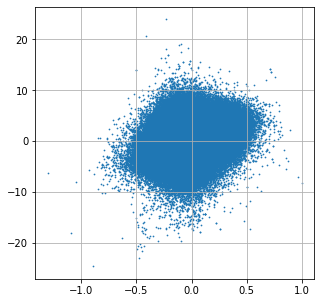

In [9]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

ax.scatter( df["zonal_velocity"], df["zonal_velocity_geo"], s=.5)
ax.grid()

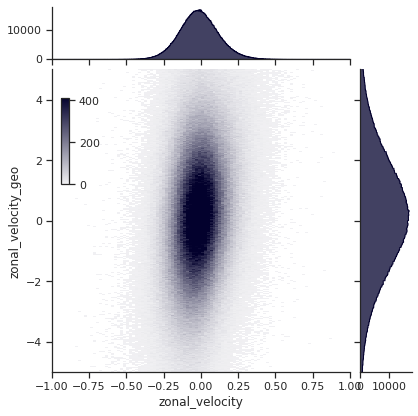

In [32]:
import seaborn as sns
sns.set_theme(style="ticks")

lims = (-5, 5)
g = sns.JointGrid(data=df, 
                  x="zonal_velocity", y="zonal_velocity_geo", 
                  marginal_ticks=True,
                  xlim=(-1, 1), ylim=(-5, 5),
                 )

# Create an inset legend for the histogram colorbar
cax = g.fig.add_axes([.15, .55, .02, .2])

# Add the joint and marginal histogram plots
g.plot_joint(
    sns.histplot, 
    binwidth = (.02, .02),
    cmap="light:#03012d", pmax=.8, cbar=True, cbar_ax=cax
)
g.plot_marginals(sns.histplot, element="step", color="#03012d")

Check amplitude of dEta_dy

In [51]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def get_proj(extent):
    lon = (extent[0]+extent[1])*.5
    lat = (extent[2]+extent[3])*.5
    return ccrs.Orthographic(central_longitude=lon, 
                     central_latitude=lat, 
                     globe=None,
                    )

extent = [-128, -123, 33, 38]
projection = get_proj(extent)

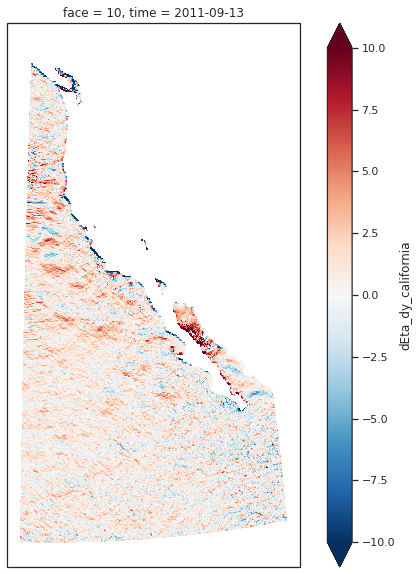

In [53]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw=dict(projection=projection))

_ds = xr.open_zarr(os.path.join(ut.diag_dir,"dEta_dy_california.zarr")).isel(time=0)

(-g*_ds["dEta_dy_california"]/f.mean()).plot(ax=ax, x="XC", y="YC", vmin=-10, vmax=10, cmap="RdBu_r", transform=ccrs.PlateCarree(),)

---

In [38]:
cluster.close()

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when job already gone
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/dask_jobqueue/core.py:360: FutureWarning: ignoring was deprecated in version 2021.06.1 and will be removed in a future release. Please use contextlib.suppress from the standard library instead.
  with ignoring(RuntimeError):  # deleting job when 